In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
folder_path = 'data\\5y\\'
csv_path = 'BTCUSDT-30m-from-2017-08-to-2021-08.csv'

df = pd.read_csv(csv_path)

In [3]:
def low(df, curr, p):
    l = min(df['Low'][curr - p + 1 : curr + 1])
    return l

#print(low(df, df.index[-1], 9))

def high(df, curr, p):
    h = max(df['High'][curr - p + 1 : curr + 1])
    return h

#print(high(df, df.index[-1], 9))

In [4]:
def sma(df, w):
    return df.iloc[:].rolling(window=w).mean()

In [5]:
def rsv(df, p):
    return [(df['Close'][df.index[curr]] - low(df, curr, p))/(high(df, curr, p) - low(df, curr, p)) for curr in range(p, len(df))]


def k(df_l, RSV, p):
    K = [0.5]
    for i in range(1, df_l - p):
        K.append((2/3)*K[i-1] + (1/3)*RSV[i])
    return K

#k(len(df), RSV, 9)

def d(df_l, K, q):
    D = [0.5]
    for i in range(1, len(K)):
        D.append((2/3)*D[i-1] + (1/3)*K[i])
    return D

#d(len(df), K, 9)

def j(df_l, K, D, p):
    return [3*K[i] - 2*D[i] for i in range(len(K))]

def kdj(df, kp, dp, jp):
    RSV = rsv(df, kp)
    K = k(len(df), RSV, kp)
    D = d(len(df), K, dp)
    J = j(len(df), K, D, jp)
    return K, D, J


In [6]:
def tri(df, i):
    return max((df['High'][i] - df['Low'][i]), abs(df['High'][i] - df['Close'][i-1]), abs(df['Low'][i] - df['Close'][i-1]))

def atr(df, curr, p):
    return (1/p)*sum([tri(df, i) for i in range(curr - p, curr)])

def maatr(df, curr, p):
    ATR = pd.DataFrame([atr(df, curr, p) for i in range(curr - p, curr)])
    SMA = sma(ATR, p)
    return SMA

In [7]:
def upmove(df, curr):
    return df['High'][curr] - df['High'][curr - 1]

def downmove(df, curr):
    return df['Low'][curr - 1] - df['Low'][curr]

def dmplus(df, curr):
    return max(0, upmove(df, curr))

def dmminus(df, curr):
    return max(0, downmove(df, curr))

def diplus(df, curr, p, w):
    dmp = pd.DataFrame([dmplus(df, i) for i in range(curr - p, curr)])
    SMA = sma(dmp[0], w)
    return SMA[SMA.index[-1]]/atr(df, curr, w)

def diminus(df, curr, p, w):
    dmm = pd.DataFrame([dmminus(df, i) for i in range(curr - p, curr)])
    SMA = sma(dmm[0], w)
    return SMA[SMA.index[-1]]/atr(df, curr, w)

In [8]:
#buy a certain amount BTC
#Now with TAXES YEAH
def buy_t(acc_usdt, acc_btc, price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= (buy_amount + buy_amount*0.001)*price
        acc_btc += buy_amount
    return acc_usdt, acc_btc

#sell a certain amount BTC
#Now with TAXES YEAH
def sell_t(acc_usdt, acc_btc, price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += (sell_amount - sell_amount*0.001)*price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc

In [9]:
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [10]:
def trader(df, w, wP, last_trade_price, last_trade_type):
    global acc_usdt
    global acc_btc
    
    kp = w
    dp = 3
    jp = 3
    K, D, J = kdj(df, kp, dp, jp)
    
    k_curr = K[-1]
    d_curr = D[-1]
    j_curr = J[-1]
    
    dplus = diplus(df, df.index[-1], w, w)
    dminus = diminus(df, df.index[-1], w, w)
    
    ATR = pd.DataFrame([atr(df, i, w) for i in range(df.index[-1] - w, df.index[-1])])
    SMA = sma(ATR, w)
    #weight = min(j_curr, 1)
    
    price = df['Close'][df.index[-1]]
    trade = True
    # SELL
    if(k_curr > d_curr and ATR[0][ATR.index[-1]] < tri(df, df.index[-1])):
        out = "Trying to sell..."
        quantity = truncate(acc_btc, 6)
        if quantity > 0.0001:
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, price, quantity)
            out = out + "Sold " + str(quantity) + "BTC at " + str(price)
            trade_type = "SELL"
        else:
            out = out + "Trade too small"
            trade = False
    # BUY
    elif(k_curr < d_curr and ATR[0][ATR.index[-1]] < tri(df, df.index[-1])):
        out = "Trying to buy..."
        quantity = truncate(((acc_usdt)/price), 6)
        if quantity > 0.0001:
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, price, quantity)
            out = out + "Bought " + str(quantity) + "BTC at " + str(price)
            trade_type = "BUY"
        else:
            out = out + "Trade too small"
            trade = False
    else:
        out = "No trade"
        trade = False
    #print(out)
    
    if trade:
        return price, trade_type, k_curr, d_curr, j_curr, dplus, dminus
    else:
        return 0, last_trade_type, k_curr, d_curr, j_curr, dplus, dminus

In [11]:
prev_time = 0
last_trade_price = 0
last_trade_type = "NONE"
out_df = pd.DataFrame([], columns = ["Timestamp", "Price", "Action", "Account Value", "Test Account Value", "K", "D", "J", "D+", "D-"])
acc_usdt = 100
acc_btc = 0

In [12]:
bdf = pd.read_csv(csv_path)

w = 5

acc_value_hist = []
prev_time = 0
last_trade_price = 0
last_trade_type = "NONE"
out_df = pd.DataFrame([], columns = ["Timestamp", "Price", "Action", "Account Value", "Test Account Value", "K", "D", "J", "D+", "D-"])
acc_usdt = 100
acc_btc = 0

out_df.to_csv("RT_w_"+str(w)+"_2.csv")

for i in range(len(bdf)-(60)):
    if i%1000==0:
        print(i)

    df = bdf.iloc[bdf.index[i:i+(3*w)]]
    df = df.astype(float)
    df = df.head(len(df)-1)

    ret_price, last_trade_type, K, D, J, dplus, dminus = trader(df, w, 1, last_trade_price, last_trade_type)
    if ret_price != 0:
        last_trade_price = ret_price
        trade_type = last_trade_type
    else:
        trade_type = "NONE"

    price = df['Close'][df.index[-1]]
    acc_value = acc_usdt + acc_btc*price
    acc_value_hist.append(acc_value)
    temp_df = pd.DataFrame([[i, price, trade_type, acc_value, acc_value, K, D, J, dplus, dminus]], columns = ["Timestamp", "Price", "Action", "Account Value", "Test Account Value", "K", "D", "J", "D+", "D-"])
    out_df = out_df.append(temp_df)

    temp_df.to_csv("RT_w_"+str(w)+"_2.csv", mode='a', header=False)
print(str(w) + " -> " + str(acc_value) + " USDT")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
5 -> 0.6825892566197006 USDT


<IPython.core.display.Javascript object>


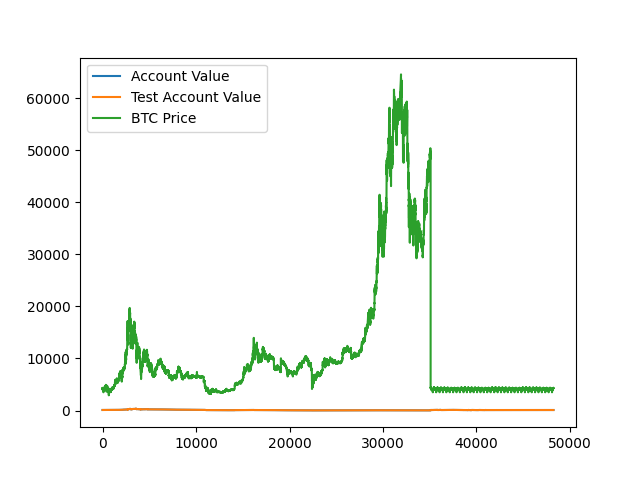

In [13]:
%matplotlib notebook
from ipywidgets import *

csv_path = 'RT_test_3.csv'

df = pd.read_csv(csv_path)

fig1, ax1 = plt.subplots()
ax1.plot(df['Account Value'], label = "Account Value")
ax1.plot(df['Test Account Value'], label = "Test Account Value")
ax1.plot(df['Price'], label = "BTC Price")
plt.legend()
fig1.canvas.resizable = True

In [14]:
    # BUY
    if(last_trade_type != "BUY" and k_curr < d_curr and dplus > 0.25):
        out = "Trying to buy..."
        quantity = truncate(((acc_usdt)/price), 6)
        if quantity > 0.0001:
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, price, quantity)
            out = out + "Bought " + str(quantity) + "BTC at " + str(price)
            trade_type = "BUY"
        else:
            out = out + "Trade too small"
            trade = False
    # SELL
    elif(last_trade_type != "SELL" and k_curr > d_curr and dminus > 0.25):
        out = "Trying to sell..."
        quantity = truncate(acc_btc, 6)
        if quantity > 0.0001:
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, price, quantity)
            out = out + "Sold " + str(quantity) + "BTC at " + str(price)
            trade_type = "SELL"
        else:
            out = out + "Trade too small"
            trade = False

NameError: name 'k_curr' is not defined